<h1 style="color:black" align="center">Настройки перед обработкой данных</h1>

**Jointplot**

In [1]:
def show_jointplot(x, y, df, kind='reg', font_scale=1.5):
    
    sns.set(font_scale=font_scale)

    grid = sns.jointplot(df[x], df[y], kind=kind)
    
    grid.fig.set_figwidth(10)
    grid.fig.set_figheight(10)

**The correlation matrix**

In [2]:
def show_corr_matrix(df, font_scale=1.1, cmap='GnBu'):
    corr = df.corr()
    plt.figure(figsize = (12, 8))
#     mask = np.tril(df.corr())
    mask = np.triu(corr)
    
    sns.set(font_scale=font_scale)
    sns.heatmap(corr, annot=True, mask=mask, fmt='.2f', square=True, linewidths=.5, cmap=cmap)
    
    plt.title('Correlation matrix')
    plt.show()

### Подключение библиотек и скриптов

In [3]:
import numpy as np
import pandas as pd

import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

from pylab import rcParams


%matplotlib inline
%config InlineBackend.figure_format = 'svg'


rcParams['figure.figsize'] = 10, 5


import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Data_preprocessing-Copy1.ipynb
./Data_preprocessing.ipynb
./Model-Copy1.ipynb
./Model.ipynb
./prediction.csv
./README.md
./.ipynb_checkpoints\Data_preprocessing-checkpoint.ipynb
./.ipynb_checkpoints\Data_preprocessing-Copy1-checkpoint.ipynb
./.ipynb_checkpoints\Model-checkpoint.ipynb
./.ipynb_checkpoints\Model-Copy1-checkpoint.ipynb
./catboost_info\catboost_training.json
./catboost_info\learn_error.tsv
./catboost_info\test_error.tsv
./catboost_info\time_left.tsv
./catboost_info\learn\events.out.tfevents
./catboost_info\test\events.out.tfevents
./input\sample_submission.csv
./input\test.csv
./input\train.csv
./save_data\housing_prepared_test.csv
./save_data\housing_prepared_train.csv
./save_data\sample_submission.csv


### Описание данных:

* `Id` - идентификационный номер квартиры

* `DistrictId` - идентификационный номер района

* `Rooms` - количество комнат

* `Square` - площадь

* `LifeSquare` - жилая площадь

* `KitchenSquare` - площадь кухни

* `Floor` - этаж

* `HouseFloor` - количество этажей в доме

* `HouseYear` - год постройки дома

* `Ecology_1, Ecology_2, Ecology_3` - экологические показатели местности

* `Social_1, Social_2, Social_3` - социальные показатели местности

* `Healthcare_1, Helthcare_2` - показатели местности, связанные с охраной здоровья

* `Shops_1, Shops_2` - показатели, связанные с наличием магазинов, торговых центров

* `Price` - цена квартиры

**Пути к директориям и файлам**

In [4]:
LOAD_TRAIN_DATASET = 'input/train.csv'
LOAD_TEST_DATASET = 'input/test.csv'

SAVE_TEST_DATASET = 'save_data/housing_prepared_test.csv'
SAVE_TRAIN_DATASET = 'save_data/housing_prepared_train.csv'

<h1 style="color:black" align="center">Загрузка данных</h1>

In [5]:
train = pd.read_csv(LOAD_TRAIN_DATASET)
test = pd.read_csv(LOAD_TEST_DATASET)

# Объединение для обработки данных
test['Price'] = ''
combine = [train, test]
combine = pd.concat(combine, ignore_index=True)

# перенесем столбец с таргетом на первое место
cols = combine.columns.tolist()
cols = cols[-1:] + cols[:-1]
combine = combine[cols]

len_train = train.shape[0]
len_combine = combine.shape[0]

### Вывод информации по данным

In [6]:
display(combine.head())
display(combine.shape)

,Price,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,184967,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
1,300009,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
2,220926,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
3,175616,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
4,150227,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


(15000, 20)

### Обзор категориальных переменных

**Получение признаков type='object'**

In [7]:
combine_obj_features = combine.select_dtypes(include='object')
combine_obj_features.head()

,Price,Ecology_2,Ecology_3,Shops_2
0,184967,B,B,B
1,300009,B,B,B
2,220926,B,B,B
3,175616,B,B,B
4,150227,B,B,B


**Получение уникальных строк для столбцов `Ecology_2	Ecology_3	Shops_2`**

In [8]:
# Выбор уникальных значений из строк
Ecology_2 = pd.DataFrame(combine_obj_features['Ecology_2'].unique(), columns=['Ecology_2'])
Ecology_3 = pd.DataFrame(combine_obj_features['Ecology_3'].unique(), columns=['Ecology_3'])
Shops_2 = pd.DataFrame(combine_obj_features['Shops_2'].unique(), columns=['Shops_2'])

# Соединение данных в один DataFrame
pd.concat([Ecology_2, Ecology_3, Shops_2], axis = 1)

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,A,A,A


При выборке уникальных строк, получили в каждом столбце строки с уникальными значениями **[`A` и `B`]**. Исходя из этого, данные требуется преобразовать к целочисленному типу данных *int8*.

Где,

**`A` = 0**

**`B` = 1**

### Замена наблюдений у признаков `Ecology_2, Ecology_3, Shops_2` к виду `A = 0, B = 1`

* **Преобразование type = 'object' к type = 'uint8'**

In [9]:
combine[['Ecology_2','Ecology_3', 'Shops_2']] = pd.get_dummies(combine[['Ecology_2','Ecology_3', 'Shops_2']], drop_first=True)

combine.head()

,Price,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,184967,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,NaN,0,11,1
1,300009,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1
2,220926,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1
3,175616,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1
4,150227,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1


<h1 style="color:black" align="center">Обработка пропусков</h1>

In [10]:
combine.isnull().sum()

Price               0
Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       3154
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     7175
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

`Healthcare_1` - Данный признак имеет большое количество пропусков $50%$, что делает замену пропусков практически бесполезной и данный признак лучше удалить. Удалить признак можно будет после визуализации данных и обучения модели;

`LifeSquare` - Можно произвести замену средним арифметическим значением, но лучше оценить закономерность с другими данными и применить другой способ замены пропусков;

### `LifeSquare` - жилая площадь

In [11]:
# Коэффициент домножения

LS_of_S = combine.loc[combine['LifeSquare'].notnull(), ['Square', 'LifeSquare']].head()

coef = (LS_of_S['LifeSquare'] / LS_of_S['Square']).mean()

**Производим замену**

In [12]:
combine.loc[(combine['LifeSquare'] < 5) | (combine['LifeSquare'].isnull()), 'LifeSquare'] = combine['Square'] * coef

### `Helthcare_1` - показатели местности, связанные с охраной здоровья

In [13]:
combine.loc[combine['Healthcare_1'].isnull(), 'Healthcare_1'] = np.round(combine["Healthcare_1"].mean())

### Проверка итоговых значений

In [14]:
combine.isnull().sum().sum()

0

<h1 style="color:black" align="center">Обработка выбросов</h1>

### Корреляция признаков

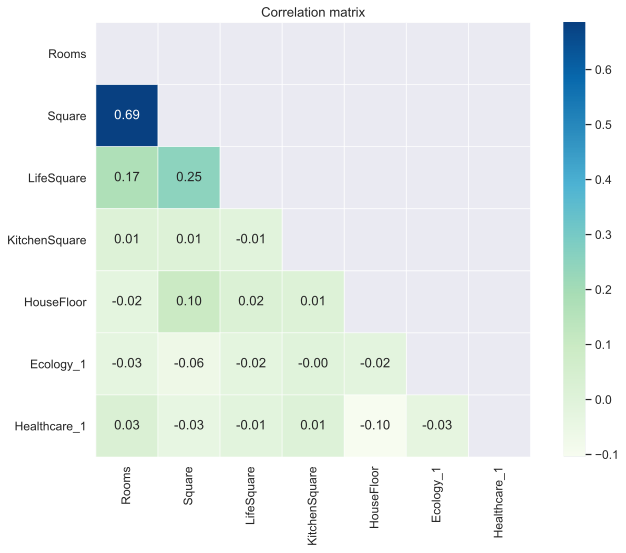

In [15]:
combine_num_features = combine.select_dtypes(include='float64')
show_corr_matrix(combine_num_features)

In [16]:
# Позволит избежать зависаний при дальнейшей визуализации данных
%config InlineBackend.figure_format = 'png2x'

# sns.set(font_scale=1.5)

# sns.pairplot(combine_num_features, corner=True, diag_kind="kde")

# plt.show()

Некоторые графики имеют огромный масштаб, это связано с большими выбрасами. После данной визуализации, можно построить каждый график более детально и обработать выбросы. 

**Статистический аналзи**

In [17]:
combine.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,8393.136933,50.693600,1.897000,56.360350,38.518109,6.174467,8.561800,12.606600,3.321575e+03,0.119196,0.990333,0.971733,24.769267,5370.404933,8.113667,1144.084733,1.319467,4.235133,0.917533
std,4850.111673,43.786257,0.839229,20.423913,63.478483,24.016979,5.323113,6.780165,1.637078e+05,0.119371,0.097846,0.165739,17.532278,4013.364403,23.841946,743.401911,1.489012,4.796545,0.275084
min,0.000000,0.000000,0.000000,1.136859,0.786925,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4188.750000,20.000000,1.000000,41.814371,26.175877,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000
50%,8378.500000,37.000000,2.000000,52.645757,34.184739,6.000000,7.000000,12.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,1144.000000,1.000000,3.000000,1.000000
75%,12594.250000,75.000000,2.000000,66.036608,45.998090,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,1144.000000,2.000000,6.000000,1.000000
max,16798.000000,212.000000,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000


### `Square`

In [18]:
mean_square = combine.loc[(combine['Rooms'] <= combine.loc[(combine['Square'] > 300), 'Rooms'].mean()), 'Square'].mean()

combine.loc[(combine['Square'] > 200), 'Square'] = mean_square

### `HouseYear`

In [19]:
mean_year = np.round(combine.loc[combine['HouseYear'] <= 2020, 'HouseYear'].mean())

combine.loc[combine['HouseYear'] > 2020, 'HouseYear'] = mean_year

### `LifeSquare`

In [20]:
combine.loc[combine['LifeSquare'] > 20]

,Price,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,184967,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,1,1,33,7976,5,1144.0,0,11,1
1,300009,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,1,1,46,10309,1,240.0,1,16,1
2,220926,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968.0,0.049637,1,1,34,7759,0,229.0,1,3,1
3,175616,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977.0,0.437885,1,1,23,5735,3,1084.0,0,5,1
4,150227,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,1,1,35,5776,1,2078.0,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973.0,0.000170,1,1,36,5992,0,1144.0,1,1,1
14996,,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017.0,0.007122,1,1,1,264,0,1144.0,0,1,1
14997,,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989.0,0.090799,1,1,74,19083,2,1144.0,5,15,1
14998,,4780,62,2.0,81.305222,56.278865,0.0,4,0.0,1977.0,0.072158,1,1,2,629,1,1144.0,0,0,0


In [21]:
combine.loc[combine['LifeSquare'] > 200, 'LifeSquare'] = combine['LifeSquare'].median()

<h1 style="color:black" align="center">Визуализация - поиск выбросов</h1>

## `LifeSquare`  от `Square`:

**Обработка значений**

### jointplot

Функция jointplot() показывает совместное распределение по двум переменным.  
Она имеет параметр kind который может принимать следующие значения:  
- “scatter”
- “reg”
- “resid”
- “kde”
- “hex”

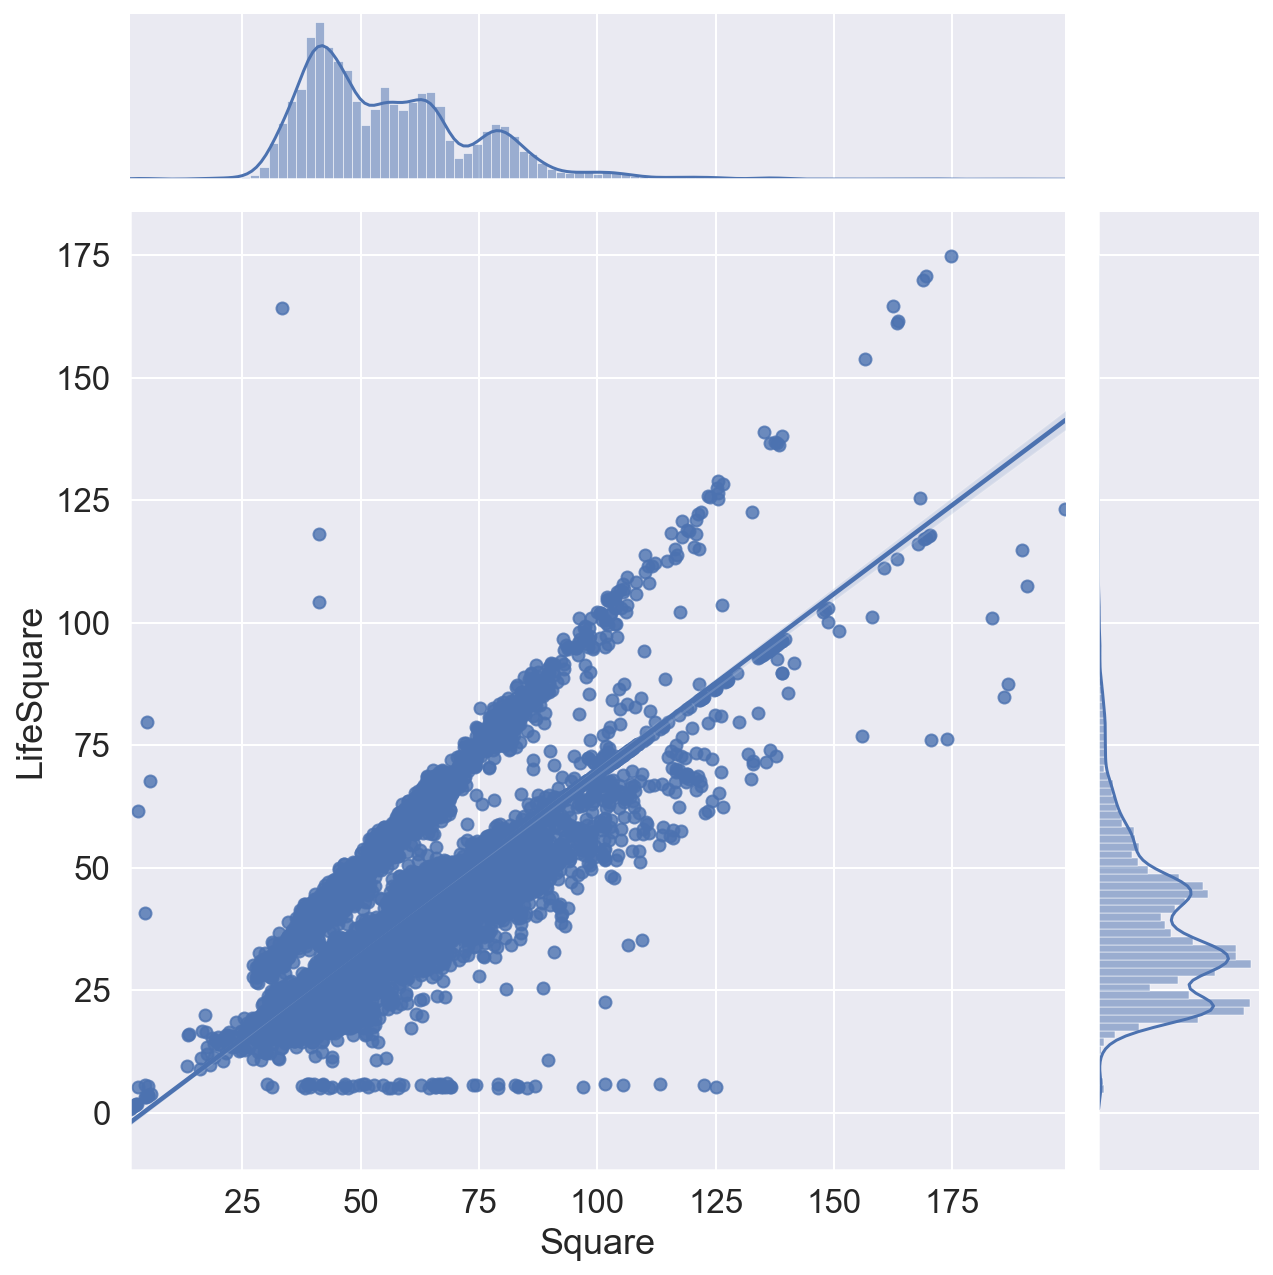

In [22]:
show_jointplot('Square', 'LifeSquare', combine)

**Жилая площадь не может быть больше общей площади**

In [23]:
combine.loc[combine['LifeSquare'] > combine['Square']] 

,Price,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
28,95338.2,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014.0,0.034656,1,1,0,168,0,1144.0,0,0,1
44,435462,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017.0,0.060753,1,1,15,2787,2,520.0,0,7,1
52,199215,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016.0,0.007122,1,1,1,264,0,1144.0,0,1,1
123,309689,8753,25,3.0,85.952306,89.803753,1.0,4,3.0,2017.0,0.069753,1,1,53,13670,4,1144.0,1,11,1
153,131797,9870,62,1.0,51.831473,53.491301,1.0,5,1.0,2015.0,0.072158,1,1,2,629,1,1144.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14927,,14686,1,3.0,77.229885,79.958685,1.0,18,17.0,1977.0,0.007122,1,1,1,264,0,1144.0,0,1,1
14951,,3711,94,1.0,41.281057,42.392594,10.0,13,13.0,2014.0,0.282798,1,1,33,8667,2,1144.0,0,6,1
14962,,5820,94,1.0,33.680382,34.198977,1.0,10,9.0,1972.0,0.127376,1,1,43,8429,3,1144.0,3,9,1
14969,,4821,74,2.0,82.542507,82.585069,0.0,4,17.0,2015.0,0.309479,1,1,35,7715,4,990.0,0,6,1


Произведём замену значений столбцов местами:

In [24]:
revert = combine.loc[combine['LifeSquare'] > combine['Square'], ['LifeSquare', 'Square']] 

for index in revert.index:
    combine['LifeSquare'][index] = revert['Square'][index]
    combine['Square'][index] = revert['LifeSquare'][index]

## `LifeSquare`  от `Rooms`:

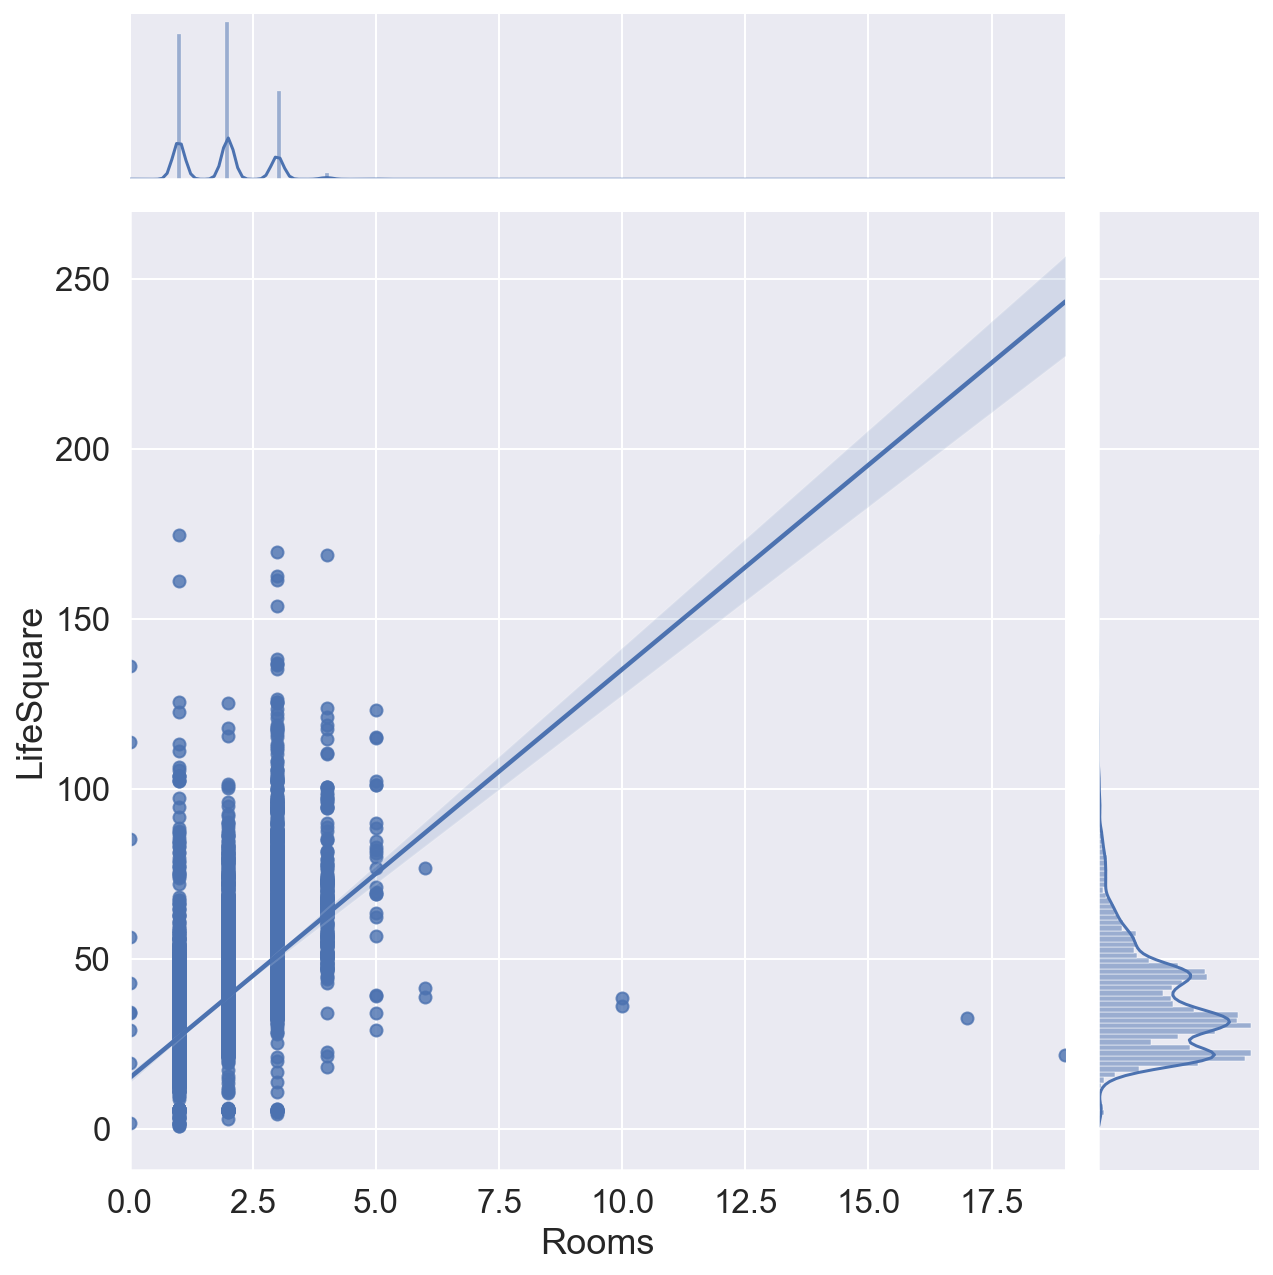

In [25]:
show_jointplot('Rooms', 'LifeSquare', combine)

**Оценка параметров**

In [26]:
for i in range(1, 7):
    median_square = combine.loc[combine['Rooms'] == i, 'LifeSquare'].median()
    print(f'Количесво комнат = {i} LifeSquare = {median_square}')

Количесво комнат = 1 LifeSquare = 23.03367632054737
Количесво комнат = 2 LifeSquare = 34.33783341478308
Количесво комнат = 3 LifeSquare = 48.30372437339385
Количесво комнат = 4 LifeSquare = 64.97344040064013
Количесво комнат = 5 LifeSquare = 79.79545136427404
Количесво комнат = 6 LifeSquare = 41.27959445151542


**Установка правильного количества комнат**

In [27]:
combine.loc[(combine['Rooms'] < 1) & (combine['LifeSquare'] < 30), 'Rooms'] = 1
combine.loc[(combine['Rooms'] < 1) & (combine['LifeSquare'] > 30) & (combine['LifeSquare'] < 45), 'Rooms'] = 2
combine.loc[(combine['Rooms'] < 1) & (combine['LifeSquare'] > 45) & (combine['LifeSquare'] < 60), 'Rooms'] = 3
combine.loc[(combine['Rooms'] < 1) & (combine['LifeSquare'] > 60) & (combine['LifeSquare'] < 75), 'Rooms'] = 4
combine.loc[(combine['Rooms'] < 1) & (combine['LifeSquare'] > 70), 'Rooms'] = 6
combine.loc[(combine['Rooms'] >= 10), 'Rooms'] = 2

## `Square`  от `Rooms`:

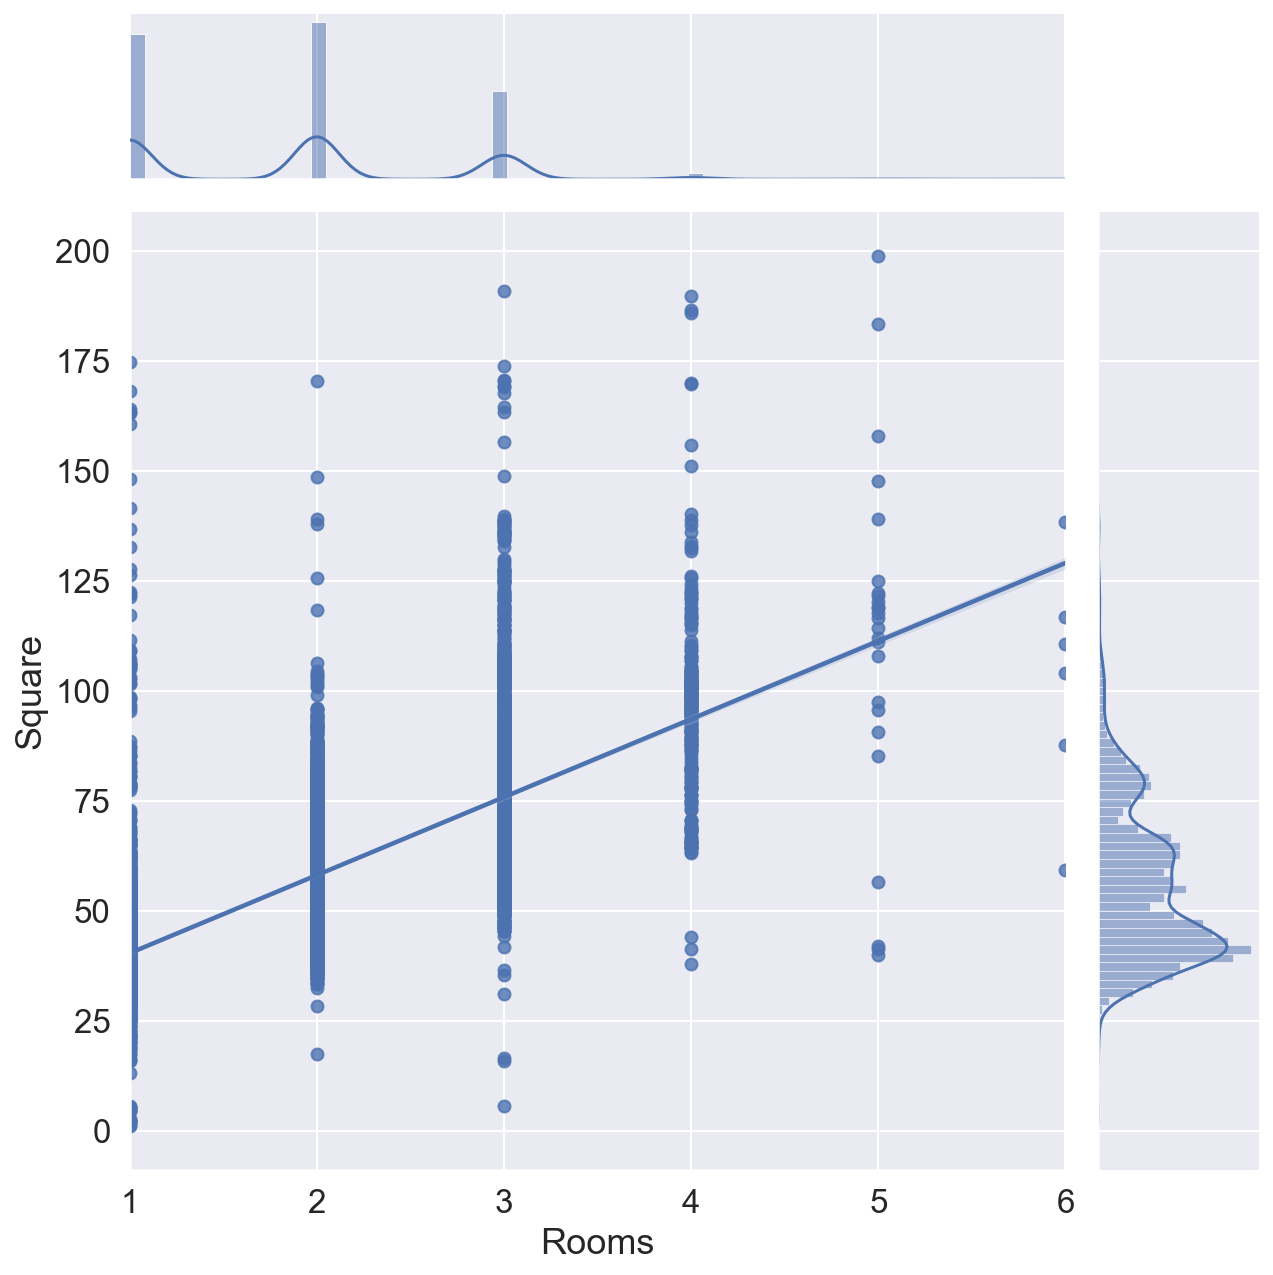

In [28]:
show_jointplot('Rooms', 'Square', combine)

**Оценка параметров**

In [29]:
for i in range(1, 7):
    median_square = combine.loc[combine['Rooms'] == i, 'Square'].median()
    print(f'Количесво комнат = {i} Square = {median_square}')

Количесво комнат = 1 Square = 40.432896157058224
Количесво комнат = 2 Square = 55.892716215451095
Количесво комнат = 3 Square = 77.57669799017502
Количесво комнат = 4 Square = 97.08727235013794
Количесво комнат = 5 Square = 116.65695474378427
Количесво комнат = 6 Square = 107.43188903239


**Установка правильного количества комнат**

In [30]:
combine.loc[(combine['Rooms'] >= 6) & (combine['Square'] < 70), 'Rooms'] = 4

In [31]:
combine.loc[(combine['Square'] > 135), 'Rooms'] = 6

In [32]:
combine.loc[(combine['Square'] < 135) & (combine['Square'] > 110) & (combine['Rooms'] < 3), 'Rooms'] = 5

combine.loc[(combine['Square'] < 110) & (combine['Square'] > 90) & (combine['Rooms'] < 3), 'Rooms'] = 4

## `Floor` от `HouseYear`

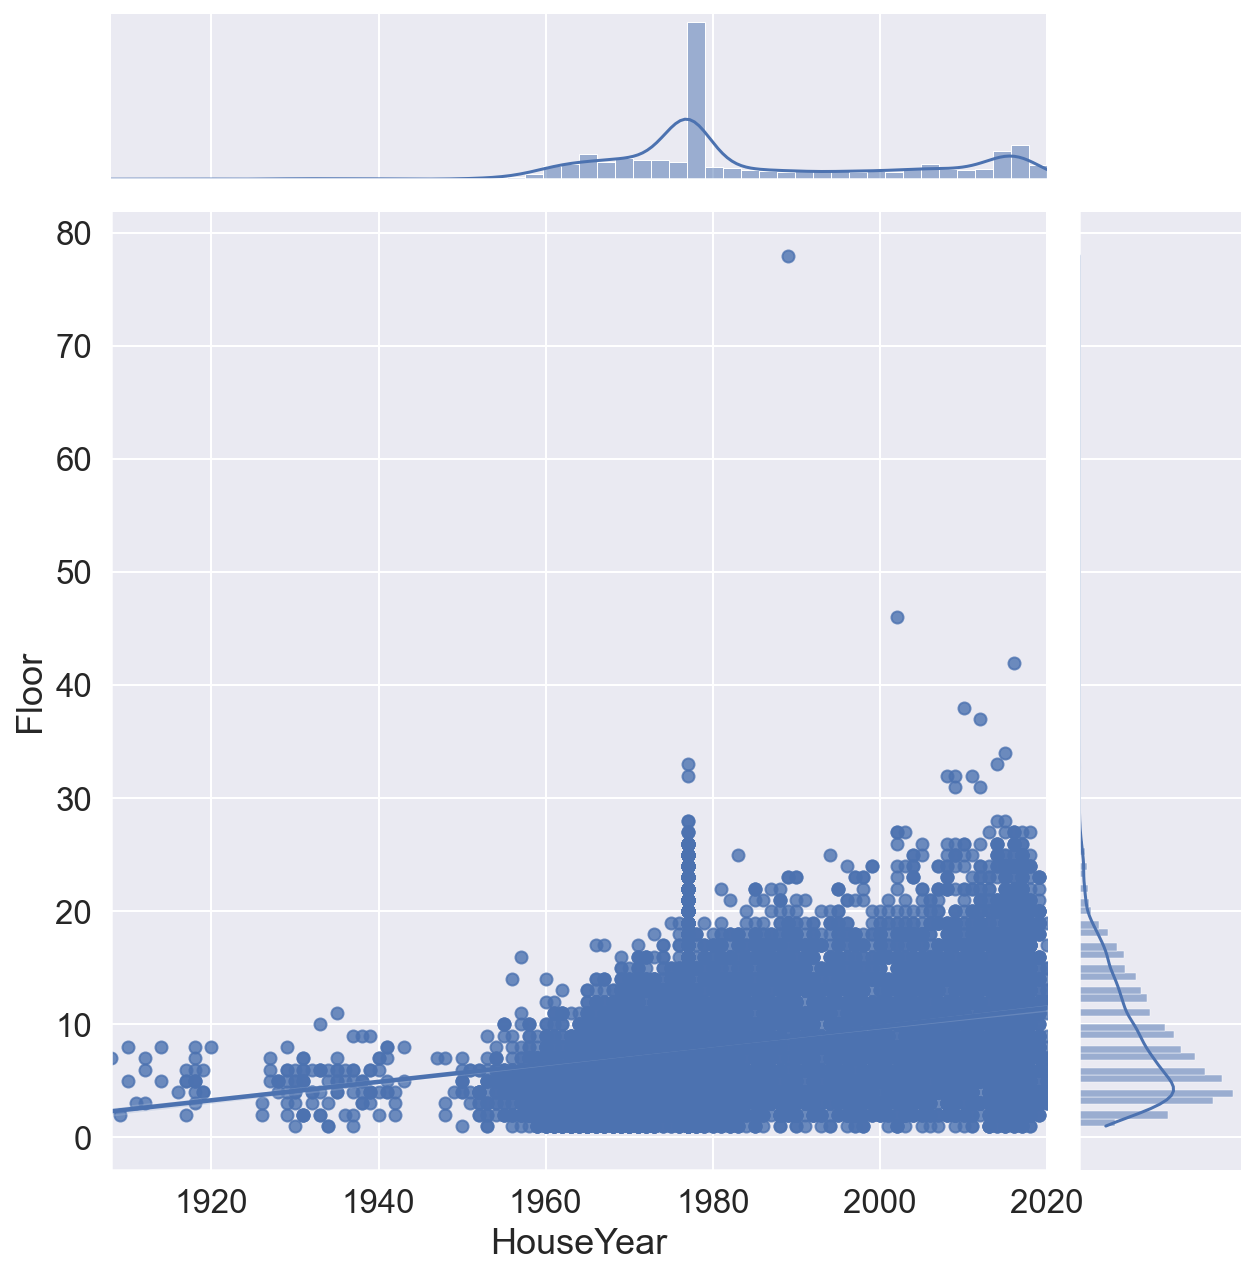

In [33]:
show_jointplot('HouseYear', 'Floor', combine)

**`HouseFloor`** - количество этажей в доме:

**Обработка ситуации, когда число этажей равно 0**

In [34]:
combine.loc[combine['HouseFloor'] == 0, 'HouseFloor'] = combine['HouseFloor'].mean()

**Обработка большого количества этажей в доме**

In [35]:
combine.loc[combine['HouseFloor'] > 50] 

,Price,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
6131,296127,10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977.0,0.150818,1,1,16,3433,4,2643.0,4,5,1
8599,243330,9300,74,2.0,74.579809,71.747869,9.0,5,99.0,1977.0,0.075779,1,1,6,1437,3,1144.0,0,2,1
8854,207248,78,30,2.0,66.811789,65.773749,1.0,8,117.0,1977.0,0.000078,1,1,22,6398,141,1046.0,3,23,1
10651,,15864,27,3.0,47.722835,47.098813,9.0,18,99.0,1977.0,0.072158,1,1,2,629,1,1144.0,0,0,0


In [36]:
combine.loc[combine['HouseFloor'] > 50, 'HouseFloor'] = combine['HouseFloor'].mean()

**`Floor`- этаж:**

**Замена значений Floor, которые больше чем HouseFloor**

In [37]:
combine.loc[combine['Floor'] > combine['HouseFloor']]

,Price,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
7,221244,11993,74,2.0,80.312926,55.592005,0.0,14,12.6066,1977.0,0.075779,1,1,6,1437,3,1144.0,0,2,1
14,140648,10953,27,1.0,53.769097,52.408027,1.0,5,4.0000,1977.0,0.072158,1,1,2,629,1,1144.0,0,0,0
16,117000,2119,27,2.0,49.360648,31.993964,5.0,6,5.0000,1983.0,0.051815,1,1,5,1227,0,1144.0,0,0,1
21,127200,11935,27,2.0,64.711835,44.793047,1.0,15,1.0000,1977.0,0.211401,1,1,9,1892,0,1144.0,0,1,1
26,337300,4378,27,3.0,106.958871,74.036129,0.0,17,12.6066,2018.0,0.072158,1,1,2,629,1,1144.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14968,,15181,27,4.0,104.664209,66.903563,1.0,4,1.0000,2016.0,0.017647,1,1,2,469,0,1144.0,0,0,1
14972,,16064,30,1.0,38.376234,37.003311,1.0,2,1.0000,1977.0,0.000078,1,1,22,6398,141,1046.0,3,23,1
14989,,2591,39,2.0,44.203592,30.191691,6.0,10,9.0000,1972.0,0.428826,1,1,25,5011,8,730.0,0,2,1
14993,,14562,113,2.0,46.627882,27.058739,5.0,6,5.0000,1969.0,0.307467,1,0,30,5048,9,325.0,2,5,1


In [38]:
revert = combine.loc[combine['Floor'] > combine['HouseFloor'], ['Floor', 'HouseFloor']]

In [39]:
for index in revert.index:
    combine['Floor'][index] = revert['HouseFloor'][index]
    combine['HouseFloor'][index] = revert['Floor'][index]

**Сохранение информации**

In [40]:
train = combine[:len_train]
test = combine[len_train:]

In [41]:
train.to_csv(SAVE_TRAIN_DATASET, index=False, encoding='utf-8')
test.to_csv(SAVE_TEST_DATASET, index=False, encoding='utf-8')